In [1]:
# importing all the required libraries

import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

#new imports from 16/07/2024
import random


In [ ]:
# Mohamed reccomendations : to drop all nans > 30%
#maybe drop patients who stayed more than ~50 hours in the ICU bc is more or less the average
#maybe rescale the SatO2 also with StandardCaler?

# Data Loading

In [2]:
df = pd.read_csv('../raw_data/Dataset.csv')

In [42]:
(df1.isnull().sum()/len(df1)).sort_values(ascending=False)

EtCO2          0.962868
Temp           0.661627
DBP            0.313459
Resp           0.153546
SBP            0.145770
O2Sat          0.130611
MAP            0.124513
HR             0.098826
Hour           0.000000
Age            0.000000
Gender         0.000000
Patient_ID     0.000000
SepsisLabel    0.000000
dtype: float64

<Axes: xlabel='Hour', ylabel='Count'>

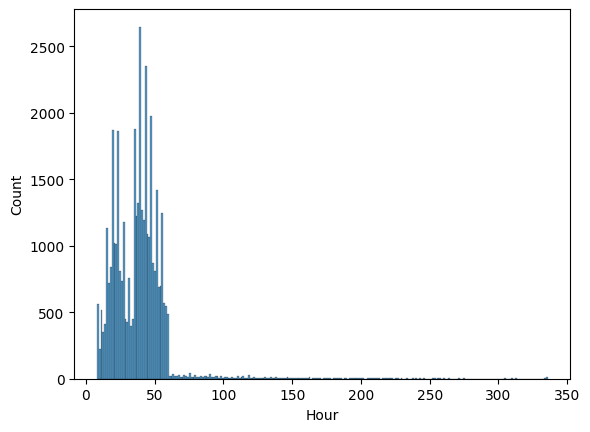

In [55]:
sns.histplot(df1.groupby('Patient_ID').Hour.count().sort_values())

# Features Selection and Data Cleaning

In [3]:
#features to drop in the dataset

columns_drop = ['Unnamed: 0','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2']

columns_for_baseline = ['Hour', 'HR','O2Sat', 'Temp','SBP', 'MAP', 'DBP', 'Resp', 'EtCO2','Age','Gender','Patient_ID','SepsisLabel']


In [4]:
df1 = df[columns_for_baseline]

# fix this as is not filtered by patient, do interpolate instead of bfill and ffill

In [60]:
# Fill NaN values with the next available value

#df_filled = df1.bfill().ffill()
df_filled = df1.interpolate().bfill().ffill()

In [61]:
df_filled.head(50)

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,Age,Gender,Patient_ID,SepsisLabel
0,0,65.0,100.0,35.780000,129.000000,72.00,69.000000,16.50,34.0,68.54,0,17072,0
1,1,65.0,100.0,35.780000,129.000000,72.00,69.000000,16.50,34.0,68.54,0,17072,0
2,2,78.0,100.0,35.780000,129.000000,42.50,69.000000,16.75,34.0,68.54,0,17072,0
3,3,73.0,100.0,35.780000,129.000000,58.25,69.000000,17.00,34.0,68.54,0,17072,0
4,4,70.0,100.0,35.780000,129.000000,74.00,69.000000,14.00,34.0,68.54,0,17072,0
5,5,62.0,100.0,35.780000,124.000000,85.00,61.000000,14.00,34.0,68.54,0,17072,0
6,6,61.0,100.0,35.780000,101.000000,75.00,58.000000,14.00,34.0,68.54,0,17072,0
7,7,68.0,100.0,35.780000,142.000000,93.50,78.000000,16.00,34.0,68.54,0,17072,0
8,8,71.0,100.0,35.932500,121.000000,74.00,91.000000,14.00,34.0,68.54,0,17072,0
9,9,69.0,100.0,36.085000,120.000000,79.00,98.000000,14.00,34.0,68.54,0,17072,0


# Data Scaling

In [71]:
columns_to_scale = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2','Age']

<Axes: xlabel='Resp', ylabel='Count'>

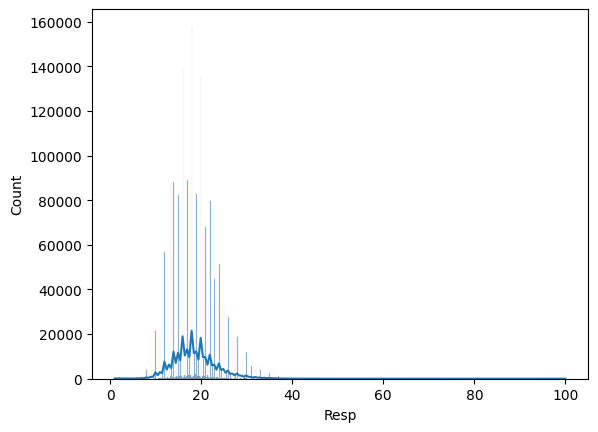

In [66]:
sns.histplot(df_filled['Resp'], kde=True)

In [72]:
# Initialize the scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply MinMaxScaler to the O2Sat column
df_filled['O2Sat'] = min_max_scaler.fit_transform(df_filled[['O2Sat']])

# Apply StandardScaler to the rest of the columns
columns_to_standardize = [col for col in columns_to_scale if col != 'O2Sat']
df_filled[columns_to_standardize] = standard_scaler.fit_transform(df_filled[columns_to_standardize])


In [73]:
df_filled

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,Age,Gender,Patient_ID,SepsisLabel
0,0,-1.129292,1.0000,-1.587190,0.229136,-0.664617,0.402095,-0.432884,0.071015,0.398538,0,17072,0
1,1,-1.129292,1.0000,-1.587190,0.229136,-0.664617,0.402095,-0.432884,0.071015,0.398538,0,17072,0
2,2,-0.372775,1.0000,-1.587190,0.229136,-2.493267,0.402095,-0.383079,0.071015,0.398538,0,17072,0
3,3,-0.663743,1.0000,-1.587190,0.229136,-1.516954,0.402095,-0.333273,0.071015,0.398538,0,17072,0
4,4,-0.838324,1.0000,-1.587190,0.229136,-0.540641,0.402095,-0.930939,0.071015,0.398538,0,17072,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552205,21,-0.081807,0.9875,-0.676864,-0.121835,-0.354677,-0.722888,0.662836,1.327498,1.586122,0,113911,0
1552206,22,-0.256388,0.9000,-0.456624,-0.955391,-0.602629,-0.947885,1.061280,1.327498,1.586122,0,113911,0
1552207,23,0.616516,0.9625,-0.236384,0.207200,0.017252,-0.385393,1.260502,1.327498,1.586122,0,113911,0
1552208,24,1.140258,0.9875,-0.236384,0.141393,0.141228,-0.347894,1.061280,1.327498,1.586122,0,113911,0


# Balancing Dataset

In [74]:
# Filter patient IDs where at some point sepsis label is 1
sepsis_patients_ids = list(set(df_filled.loc[df_filled['SepsisLabel'] == 1, 'Patient_ID'].tolist()))

In [75]:
# Get unique Patient_IDs from df_encoded
all_patient_ids = set(df_filled['Patient_ID'])
# Find Patient_IDs not in sepsis_patients_ids
no_sepsis_patients_ids = list(all_patient_ids - set(sepsis_patients_ids))

In [76]:
#Now we have the list with the ID's with patients that had sepsis and patients which doesn't
len(sepsis_patients_ids), len(no_sepsis_patients_ids)

(2932, 37404)

In [77]:
non_sepsis_selected_patients_ids = random.sample(no_sepsis_patients_ids, 4000)

In [78]:
non_sepsis_selected_df = df_filled.loc[df_filled['Patient_ID'].isin(non_sepsis_selected_patients_ids)]
sepsis_selected_df = df_filled.loc[df_filled['Patient_ID'].isin(sepsis_patients_ids)]

In [79]:
final_df = pd.concat([non_sepsis_selected_df,sepsis_selected_df])

In [80]:
patient_ids = final_df['Patient_ID'].unique()
np.random.shuffle(patient_ids)

In [81]:
final_df.Patient_ID = final_df.Patient_ID.astype("category")
final_df.Patient_ID = final_df.Patient_ID.cat.set_categories(patient_ids)
final_df_shuffled = final_df.sort_values(["Patient_ID","Hour"]).set_index('Patient_ID')  ## 'sort' changed to 'patient_ids'

In [82]:
final_df_shuffled

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,Age,Gender,SepsisLabel
Patient_ID,,,,,,,,,,,,
5605,0,0.121870,0.98750,-0.207018,1.369791,0.843554,-0.951346,0.513420,0.071015,1.010638,0,0
5605,1,-0.314582,1.00000,0.446361,0.316878,-0.065192,-0.949615,0.662836,0.071015,1.010638,0,0
5605,2,-0.489162,0.98750,1.099740,-1.152812,-1.016090,-0.947885,0.463614,0.071015,1.010638,0,0
5605,3,-0.576453,1.00000,1.085057,-0.056028,-0.261694,-0.872886,-0.632106,0.071015,1.010638,0,0
5605,4,-0.663743,1.00000,1.070374,-0.450870,-0.664617,-1.247880,0.463614,0.071015,1.010638,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
117721,13,-0.314582,0.98750,-1.484411,-0.999262,-0.354677,-0.047898,-2.923158,0.875949,0.182503,0,1
117721,14,0.034580,0.98750,-1.300877,-0.999262,0.079240,0.927087,-2.365337,0.895582,0.182503,0,1
117721,15,-0.576453,0.98125,-1.117344,-0.736034,-0.075730,0.252097,-1.807516,0.915214,0.182503,0,1


# Tabular Data Shifting for 1rst Baseline Model Approach

In [83]:
features_df = final_df_shuffled.drop(columns = ['Hour','Age','Gender','SepsisLabel'])
to_add_df = final_df_shuffled[['Hour','Age','Gender','SepsisLabel']]

In [84]:
balanced_shifted_df = pd.concat([

                    features_df,
                    features_df.groupby(features_df.index).shift(1).add_suffix('_1'),
                    features_df.groupby(features_df.index).shift(2).add_suffix('_2'),
                    features_df.groupby(features_df.index).shift(3).add_suffix('_3'),
                    features_df.groupby(features_df.index).shift(4).add_suffix('_4'),
                    features_df.groupby(features_df.index).shift(5).add_suffix('_5'),
                    to_add_df],
                    axis=1
)

/tmp/ipykernel_67332/3567530738.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  features_df.groupby(features_df.index).shift(1).add_suffix('_1'),
/tmp/ipykernel_67332/3567530738.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  features_df.groupby(features_df.index).shift(2).add_suffix('_2'),
/tmp/ipykernel_67332/3567530738.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  features_df.groupby(features_df.index).s

In [85]:
pd.set_option('display.max_columns', None)

In [92]:
balanced_shifted_df.loc[5605]

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,HR_1,O2Sat_1,Temp_1,SBP_1,MAP_1,DBP_1,Resp_1,EtCO2_1,HR_2,O2Sat_2,Temp_2,SBP_2,MAP_2,DBP_2,Resp_2,EtCO2_2,HR_3,O2Sat_3,Temp_3,SBP_3,MAP_3,DBP_3,Resp_3,EtCO2_3,HR_4,O2Sat_4,Temp_4,SBP_4,MAP_4,DBP_4,Resp_4,EtCO2_4,HR_5,O2Sat_5,Temp_5,SBP_5,MAP_5,DBP_5,Resp_5,EtCO2_5,Hour,Age,Gender,SepsisLabel
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5605,0.121870,0.9875,-0.207018,1.369791,0.843554,-0.951346,0.513420,0.071015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.010638,0,0
5605,-0.314582,1.0000,0.446361,0.316878,-0.065192,-0.949615,0.662836,0.071015,0.121870,0.9875,-0.207018,1.369791,0.843554,-0.951346,0.513420,0.071015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.010638,0,0
5605,-0.489162,0.9875,1.099740,-1.152812,-1.016090,-0.947885,0.463614,0.071015,-0.314582,1.0000,0.446361,0.316878,-0.065192,-0.949615,0.662836,0.071015,0.121870,0.9875,-0.207018,1.369791,0.843554,-0.951346,0.513420,0.071015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.010638,0,0
5605,-0.576453,1.0000,1.085057,-0.056028,-0.261694,-0.872886,-0.632106,0.071015,-0.489162,0.9875,1.099740,-1.152812,-1.016090,-0.947885,0.463614,0.071015,-0.314582,1.0000,0.446361,0.316878,-0.065192,-0.949615,0.662836,0.071015,0.121870,0.9875,-0.207018,1.369791,0.843554,-0.951346,0.513420,0.071015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1.010638,0,0
5605,-0.663743,1.0000,1.070374,-0.450870,-0.664617,-1.247880,0.463614,0.071015,-0.576453,1.0000,1.085057,-0.056028,-0.261694,-0.872886,-0.632106,0.071015,-0.489162,0.9875,1.099740,-1.152812,-1.016090,-0.947885,0.463614,0.071015,-0.314582,1.0000,0.446361,0.316878,-0.065192,-0.949615,0.662836,0.071015,0.121870,0.9875,-0.207018,1.369791,0.843554,-0.951346,0.513420,0.071015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1.010638,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5605,1.978246,0.9625,2.230305,0.246684,0.050478,0.576199,1.698790,0.071015,1.856040,0.9625,1.936652,0.264233,0.042171,0.536021,1.439802,0.071015,1.733833,0.9625,1.642998,0.281781,0.033865,0.495843,1.180813,0.071015,1.611626,0.9625,1.349345,0.299330,0.025559,0.455665,0.921825,0.071015,1.489420,0.9625,1.327321,0.316878,0.017252,0.415487,0.662836,0.071015,1.373033,0.9625,1.305297,0.755592,-0.850582,0.375309,0.065171,0.071015,173,1.010638,0,1
5605,2.100453,0.9625,2.523959,0.229136,0.058784,0.616377,1.957779,0.071015,1.978246,0.9625,2.230305,0.246684,0.050478,0.576199,1.698790,0.071015,1.856040,0.9625,1.936652,0.264233,0.042171,0.536021,1.439802,0.071015,1.733833,0.9625,1.642998,0.281781,0.033865,0.495843,1.180813,0.071015,1.611626,0.9625,1.349345,0.299330,0.025559,0.455665,0.921825,0.071015,1.489420,0.9625,1.327321,0.316878,0.017252,0.415487,0.662836,0.071015,174,1.010638,0,1
5605,2.420517,0.9750,2.817612,0.448493,0.161685,0.656555,1.858168,0.071015,2.100453,0.9625,2.523959,0.229136,0.058784,0.616377,1.957779,0.071015,1.978246,0.9625,2.230305,0.246684,0.050478,0.576199,1.698790,0.071015,1.856040,0.9625,1.936652,0.264233,0.042171,0.536021,1.439802,0.071015,1.733833,0.9625,1.642998,0.281781,0.033865,0.495843,1.180813,0.071015,1.611626,0.9625,1.349345,0.299330,0.025559,0.455665,0.921825,0.071015,175,1.010638,0,1


In [89]:
balanced_shifted_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,HR_1,O2Sat_1,Temp_1,SBP_1,MAP_1,DBP_1,Resp_1,EtCO2_1,HR_2,O2Sat_2,Temp_2,SBP_2,MAP_2,DBP_2,Resp_2,EtCO2_2,HR_3,O2Sat_3,Temp_3,SBP_3,MAP_3,DBP_3,Resp_3,EtCO2_3,HR_4,O2Sat_4,Temp_4,SBP_4,MAP_4,DBP_4,Resp_4,EtCO2_4,HR_5,O2Sat_5,Temp_5,SBP_5,MAP_5,DBP_5,Resp_5,EtCO2_5,Hour,Age,Gender,SepsisLabel
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5605,0.121870,0.98750,-0.207018,1.369791,0.843554,-0.951346,0.513420,0.071015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.010638,0,0
5605,-0.314582,1.00000,0.446361,0.316878,-0.065192,-0.949615,0.662836,0.071015,0.121870,0.98750,-0.207018,1.369791,0.843554,-0.951346,0.513420,0.071015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.010638,0,0
5605,-0.489162,0.98750,1.099740,-1.152812,-1.016090,-0.947885,0.463614,0.071015,-0.314582,1.00000,0.446361,0.316878,-0.065192,-0.949615,0.662836,0.071015,0.121870,0.98750,-0.207018,1.369791,0.843554,-0.951346,0.513420,0.071015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.010638,0,0
5605,-0.576453,1.00000,1.085057,-0.056028,-0.261694,-0.872886,-0.632106,0.071015,-0.489162,0.98750,1.099740,-1.152812,-1.016090,-0.947885,0.463614,0.071015,-0.314582,1.00000,0.446361,0.316878,-0.065192,-0.949615,0.662836,0.071015,0.121870,0.9875,-0.207018,1.369791,0.843554,-0.951346,0.513420,0.071015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1.010638,0,0
5605,-0.663743,1.00000,1.070374,-0.450870,-0.664617,-1.247880,0.463614,0.071015,-0.576453,1.00000,1.085057,-0.056028,-0.261694,-0.872886,-0.632106,0.071015,-0.489162,0.98750,1.099740,-1.152812,-1.016090,-0.947885,0.463614,0.071015,-0.314582,1.0000,0.446361,0.316878,-0.065192,-0.949615,0.662836,0.071015,0.121870,0.9875,-0.207018,1.369791,0.843554,-0.951346,0.513420,0.071015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1.010638,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117721,-0.314582,0.98750,-1.484411,-0.999262,-0.354677,-0.047898,-2.923158,0.875949,0.150967,0.98750,-1.667944,0.360750,0.823098,1.452079,-3.520824,0.856316,1.169355,0.98750,-1.851478,0.931078,1.442979,1.527078,-3.520824,0.836684,-0.809227,0.9750,-1.943244,-0.911520,-0.292689,0.177098,-3.082536,0.817051,-1.129292,0.9875,-2.035011,-1.218619,-0.788594,-0.422893,-2.644248,0.797419,-0.547356,0.9625,-2.126778,-1.065069,-0.695611,-0.422893,-2.205959,0.777786,13,0.182503,0,1
117721,0.034580,0.98750,-1.300877,-0.999262,0.079240,0.927087,-2.365337,0.895582,-0.314582,0.98750,-1.484411,-0.999262,-0.354677,-0.047898,-2.923158,0.875949,0.150967,0.98750,-1.667944,0.360750,0.823098,1.452079,-3.520824,0.856316,1.169355,0.9875,-1.851478,0.931078,1.442979,1.527078,-3.520824,0.836684,-0.809227,0.9750,-1.943244,-0.911520,-0.292689,0.177098,-3.082536,0.817051,-1.129292,0.9875,-2.035011,-1.218619,-0.788594,-0.422893,-2.644248,0.797419,14,0.182503,0,1
117721,-0.576453,0.98125,-1.117344,-0.736034,-0.075730,0.252097,-1.807516,0.915214,0.034580,0.98750,-1.300877,-0.999262,0.079240,0.927087,-2.365337,0.895582,-0.314582,0.98750,-1.484411,-0.999262,-0.354677,-0.047898,-2.923158,0.875949,0.150967,0.9875,-1.667944,0.360750,0.823098,1.452079,-3.520824,0.856316,1.169355,0.9875,-1.851478,0.931078,1.442979,1.527078,-3.520824,0.836684,-0.809227,0.9750,-1.943244,-0.911520,-0.292689,0.177098,-3.082536,0.817051,15,0.182503,0,1


In [86]:
balanced_shifted_cleaned_df = balanced_shifted_df.dropna()

In [87]:
balanced_shifted_cleaned_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,HR_1,O2Sat_1,Temp_1,SBP_1,MAP_1,DBP_1,Resp_1,EtCO2_1,HR_2,O2Sat_2,Temp_2,SBP_2,MAP_2,DBP_2,Resp_2,EtCO2_2,HR_3,O2Sat_3,Temp_3,SBP_3,MAP_3,DBP_3,Resp_3,EtCO2_3,HR_4,O2Sat_4,Temp_4,SBP_4,MAP_4,DBP_4,Resp_4,EtCO2_4,HR_5,O2Sat_5,Temp_5,SBP_5,MAP_5,DBP_5,Resp_5,EtCO2_5,Hour,Age,Gender,SepsisLabel
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5605,-0.644345,1.00000,1.055691,-0.385063,-0.519978,-1.047883,-0.233662,0.071015,-0.663743,1.00000,1.070374,-0.450870,-0.664617,-1.247880,0.463614,0.071015,-0.576453,1.00000,1.085057,-0.056028,-0.261694,-0.872886,-0.632106,0.071015,-0.489162,0.9875,1.099740,-1.152812,-1.016090,-0.947885,0.463614,0.071015,-0.314582,1.0000,0.446361,0.316878,-0.065192,-0.949615,0.662836,0.071015,0.121870,0.9875,-0.207018,1.369791,0.843554,-0.951346,0.513420,0.071015,5,1.010638,0,0
5605,-0.624948,1.00000,1.041009,-0.319256,-0.375339,-0.847886,-0.930939,0.071015,-0.644345,1.00000,1.055691,-0.385063,-0.519978,-1.047883,-0.233662,0.071015,-0.663743,1.00000,1.070374,-0.450870,-0.664617,-1.247880,0.463614,0.071015,-0.576453,1.0000,1.085057,-0.056028,-0.261694,-0.872886,-0.632106,0.071015,-0.489162,0.9875,1.099740,-1.152812,-1.016090,-0.947885,0.463614,0.071015,-0.314582,1.0000,0.446361,0.316878,-0.065192,-0.949615,0.662836,0.071015,6,1.010638,0,0
5605,-0.605550,1.00000,1.026326,-0.253449,-0.230700,-0.647889,-0.930939,0.071015,-0.624948,1.00000,1.041009,-0.319256,-0.375339,-0.847886,-0.930939,0.071015,-0.644345,1.00000,1.055691,-0.385063,-0.519978,-1.047883,-0.233662,0.071015,-0.663743,1.0000,1.070374,-0.450870,-0.664617,-1.247880,0.463614,0.071015,-0.576453,1.0000,1.085057,-0.056028,-0.261694,-0.872886,-0.632106,0.071015,-0.489162,0.9875,1.099740,-1.152812,-1.016090,-0.947885,0.463614,0.071015,7,1.010638,0,0
5605,-0.896518,1.00000,0.861880,-0.385063,-0.354677,-0.872886,-0.930939,0.071015,-0.605550,1.00000,1.026326,-0.253449,-0.230700,-0.647889,-0.930939,0.071015,-0.624948,1.00000,1.041009,-0.319256,-0.375339,-0.847886,-0.930939,0.071015,-0.644345,1.0000,1.055691,-0.385063,-0.519978,-1.047883,-0.233662,0.071015,-0.663743,1.0000,1.070374,-0.450870,-0.664617,-1.247880,0.463614,0.071015,-0.576453,1.0000,1.085057,-0.056028,-0.261694,-0.872886,-0.632106,0.071015,8,1.010638,0,0
5605,-0.692840,0.93125,0.697434,-0.209578,-0.106724,-0.610390,-0.532495,0.071015,-0.896518,1.00000,0.861880,-0.385063,-0.354677,-0.872886,-0.930939,0.071015,-0.605550,1.00000,1.026326,-0.253449,-0.230700,-0.647889,-0.930939,0.071015,-0.624948,1.0000,1.041009,-0.319256,-0.375339,-0.847886,-0.930939,0.071015,-0.644345,1.0000,1.055691,-0.385063,-0.519978,-1.047883,-0.233662,0.071015,-0.663743,1.0000,1.070374,-0.450870,-0.664617,-1.247880,0.463614,0.071015,9,1.010638,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117721,-0.314582,0.98750,-1.484411,-0.999262,-0.354677,-0.047898,-2.923158,0.875949,0.150967,0.98750,-1.667944,0.360750,0.823098,1.452079,-3.520824,0.856316,1.169355,0.98750,-1.851478,0.931078,1.442979,1.527078,-3.520824,0.836684,-0.809227,0.9750,-1.943244,-0.911520,-0.292689,0.177098,-3.082536,0.817051,-1.129292,0.9875,-2.035011,-1.218619,-0.788594,-0.422893,-2.644248,0.797419,-0.547356,0.9625,-2.126778,-1.065069,-0.695611,-0.422893,-2.205959,0.777786,13,0.182503,0,1
117721,0.034580,0.98750,-1.300877,-0.999262,0.079240,0.927087,-2.365337,0.895582,-0.314582,0.98750,-1.484411,-0.999262,-0.354677,-0.047898,-2.923158,0.875949,0.150967,0.98750,-1.667944,0.360750,0.823098,1.452079,-3.520824,0.856316,1.169355,0.9875,-1.851478,0.931078,1.442979,1.527078,-3.520824,0.836684,-0.809227,0.9750,-1.943244,-0.911520,-0.292689,0.177098,-3.082536,0.817051,-1.129292,0.9875,-2.035011,-1.218619,-0.788594,-0.422893,-2.644248,0.797419,14,0.182503,0,1
117721,-0.576453,0.98125,-1.117344,-0.736034,-0.075730,0.252097,-1.807516,0.915214,0.034580,0.98750,-

In [29]:
log_reg_df = balanced_shifted_cleaned_df.drop('Hour',axis=1)

# Data Split

In [30]:
# Split the data into training and testing sets, we have 5545 patients for train and 1386 for test so a total of 1386 + 5545 = 6931 patients
split_point = int(0.8 * len(patient_ids))  # 80% train, 20% test
split_point

5545

In [31]:
train_ids = patient_ids[:split_point]
test_ids = patient_ids[split_point:]

In [32]:
train_df = log_reg_df.loc[log_reg_df.index.isin(train_ids)]
test_df = log_reg_df.loc[log_reg_df.index.isin(test_ids)]


In [46]:
train_df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,HR_1,O2Sat_1,Temp_1,SBP_1,MAP_1,DBP_1,Resp_1,EtCO2_1,HR_2,O2Sat_2,Temp_2,SBP_2,MAP_2,DBP_2,Resp_2,EtCO2_2,HR_3,O2Sat_3,Temp_3,SBP_3,MAP_3,DBP_3,Resp_3,EtCO2_3,HR_4,O2Sat_4,Temp_4,SBP_4,MAP_4,DBP_4,Resp_4,EtCO2_4,HR_5,O2Sat_5,Temp_5,SBP_5,MAP_5,DBP_5,Resp_5,EtCO2_5,Age,Gender,SepsisLabel
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11771,1.469549,0.97500,1.155645,-0.984851,-0.231066,0.379856,-0.514133,0.096771,1.527079,0.98750,1.019710,-0.813092,-0.109377,0.524747,-0.514133,0.096771,1.181900,0.99375,1.019710,-0.684273,-0.139799,0.488524,-0.514133,0.096771,1.296960,1.00000,0.747842,-0.491045,0.103579,0.742084,-0.514133,0.096771,0.894250,1.00000,0.747842,-0.533984,0.042734,0.669638,-0.514133,0.096771,1.009310,0.98125,0.272072,-0.705743,-0.078955,0.560970,-1.291060,0.096771,-1.471327,1,0
11771,1.584609,0.98750,1.563447,-0.941911,-0.291911,0.379856,-0.514133,0.096771,1.469549,0.97500,1.155645,-0.984851,-0.231066,0.379856,-0.514133,0.096771,1.527079,0.98750,1.019710,-0.813092,-0.109377,0.524747,-0.514133,0.096771,1.181900,0.99375,1.019710,-0.684273,-0.139799,0.488524,-0.514133,0.096771,1.296960,1.00000,0.747842,-0.491045,0.103579,0.742084,-0.514133,0.096771,0.894250,1.00000,0.747842,-0.533984,0.042734,0.669638,-0.514133,0.096771,-1.471327,1,0
11771,1.757199,0.98750,1.971250,-0.856032,-0.231066,0.452301,-0.514133,0.096771,1.584609,0.98750,1.563447,-0.941911,-0.291911,0.379856,-0.514133,0.096771,1.469549,0.97500,1.155645,-0.984851,-0.231066,0.379856,-0.514133,0.096771,1.527079,0.98750,1.019710,-0.813092,-0.109377,0.524747,-0.514133,0.096771,1.181900,0.99375,1.019710,-0.684273,-0.139799,0.488524,-0.514133,0.096771,1.296960,1.00000,0.747842,-0.491045,0.103579,0.742084,-0.514133,0.096771,-1.471327,1,0
11771,1.814729,0.95000,1.971250,-0.684273,-0.170222,0.379856,-0.514133,0.096771,1.757199,0.98750,1.971250,-0.856032,-0.231066,0.452301,-0.514133,0.096771,1.584609,0.98750,1.563447,-0.941911,-0.291911,0.379856,-0.514133,0.096771,1.469549,0.97500,1.155645,-0.984851,-0.231066,0.379856,-0.514133,0.096771,1.527079,0.98750,1.019710,-0.813092,-0.109377,0.524747,-0.514133,0.096771,1.181900,0.99375,1.019710,-0.684273,-0.139799,0.488524,-0.514133,0.096771,-1.471327,1,0
11771,1.412019,0.96250,1.971250,-0.727213,-0.352756,0.017628,-0.514133,0.096771,1.814729,0.95000,1.971250,-0.684273,-0.170222,0.379856,-0.514133,0.096771,1.757199,0.98750,1.971250,-0.856032,-0.231066,0.452301,-0.514133,0.096771,1.584609,0.98750,1.563447,-0.941911,-0.291911,0.379856,-0.514133,0.096771,1.469549,0.97500,1.155645,-0.984851,-0.231066,0.379856,-0.514133,0.096771,1.527079,0.98750,1.019710,-0.813092,-0.109377,0.524747,-0.514133,0.096771,-1.471327,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108171,-0.371409,0.96250,0.204105,1.462710,1.350893,0.886975,-1.096828,0.228113,-0.601529,0.96875,0.204105,0.432158,0.255691,-0.199709,-1.096828,0.096771,-0.342644,0.95625,0.475973,0.603917,0.255691,-0.272155,-1.096828,0.228113,-0.256349,0.92500,0.475973,0.775676,0.559914,0.017628,-1.096828,0.359455,-0.141289,0.95000,0.475973,0.861555,0.985826,0.488524,-1.096828,0.096771,-0.141289,0.93750,0.475973,1.119193,1.350893,1.176758,-1.096828,0.096771,-1.465224,0,1
108171,-0.486469,0.97500,0.204105,0.861555,0.316535,-0.199709,-1.096828,0.359455,-0.371409,0.96250,0.204105,1.462710,1.350893,0.886975,-1.096828,0.228113,-0.601529,0.96875,0.204105,0.432158,0.255691,-0.199709,-1.096828,0.096771,-0.342644,0.95625,0.475973,0.603917,0.255691,-0.272155,-1.096828,0.228113,-0.256349,0.92500,0.475973,0.775676,0.559914,0.017628,-1.096828,0.359455,-0.141289,0.95000,0.475973,0.861555,0.985826,0.488524,-1.096828,0.096771,-1.465224,0,1
108171,-0.342644,0.91250,0.204105,0.475098,0.559914,0.234964,-1.096828,0.096771,-0.486469,0.97500,0.204105,0.861555,0.316535,-0.199709,-1.096828,0.359455,-0.371409,0.

# Baseline Model Logistic Regression 1rst approach

In [33]:
X_train = train_df.drop('SepsisLabel',axis=1)
y_train = train_df['SepsisLabel']

In [47]:
X_test

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,HR_1,O2Sat_1,Temp_1,SBP_1,MAP_1,DBP_1,Resp_1,EtCO2_1,HR_2,O2Sat_2,Temp_2,SBP_2,MAP_2,DBP_2,Resp_2,EtCO2_2,HR_3,O2Sat_3,Temp_3,SBP_3,MAP_3,DBP_3,Resp_3,EtCO2_3,HR_4,O2Sat_4,Temp_4,SBP_4,MAP_4,DBP_4,Resp_4,EtCO2_4,HR_5,O2Sat_5,Temp_5,SBP_5,MAP_5,DBP_5,Resp_5,EtCO2_5,Age,Gender
Patient_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
890,0.836720,0.9750,-0.557127,1.290952,0.012312,0.959421,0.845490,0.096771,1.066840,0.9875,-0.557127,1.290952,-0.048533,0.959421,1.816650,0.096771,0.664130,0.9625,-0.557127,1.290952,-0.048533,0.959421,-0.319901,0.096771,0.606600,0.9500,-0.557127,1.290952,-1.143735,0.959421,-0.319901,0.096771,0.664130,0.9500,-0.557127,1.290952,-0.839512,0.959421,0.068563,0.096771,0.664130,0.9500,-0.557127,1.290952,-0.839512,0.959421,0.068563,0.096771,0.216678,0
890,0.721660,0.9500,-0.557127,1.290952,-0.413600,0.959421,0.457027,0.096771,0.836720,0.9750,-0.557127,1.290952,0.012312,0.959421,0.845490,0.096771,1.066840,0.9875,-0.557127,1.290952,-0.048533,0.959421,1.816650,0.096771,0.664130,0.9625,-0.557127,1.290952,-0.048533,0.959421,-0.319901,0.096771,0.606600,0.9500,-0.557127,1.290952,-1.143735,0.959421,-0.319901,0.096771,0.664130,0.9500,-0.557127,1.290952,-0.839512,0.959421,0.068563,0.096771,0.216678,0
890,0.491540,0.9625,-0.326039,1.290952,-0.231066,0.959421,0.068563,0.096771,0.721660,0.9500,-0.557127,1.290952,-0.413600,0.959421,0.457027,0.096771,0.836720,0.9750,-0.557127,1.290952,0.012312,0.959421,0.845490,0.096771,1.066840,0.9875,-0.557127,1.290952,-0.048533,0.959421,1.816650,0.096771,0.664130,0.9625,-0.557127,1.290952,-0.048533,0.959421,-0.319901,0.096771,0.606600,0.9500,-0.557127,1.290952,-1.143735,0.959421,-0.319901,0.096771,0.216678,0
890,0.434010,0.9625,-0.326039,1.290952,-0.109377,0.959421,-0.514133,0.096771,0.491540,0.9625,-0.326039,1.290952,-0.231066,0.959421,0.068563,0.096771,0.721660,0.9500,-0.557127,1.290952,-0.413600,0.959421,0.457027,0.096771,0.836720,0.9750,-0.557127,1.290952,0.012312,0.959421,0.845490,0.096771,1.066840,0.9875,-0.557127,1.290952,-0.048533,0.959421,1.816650,0.096771,0.664130,0.9625,-0.557127,1.290952,-0.048533,0.959421,-0.319901,0.096771,0.216678,0
890,0.721660,0.9625,-0.326039,1.290952,-0.109377,0.959421,1.039722,0.096771,0.434010,0.9625,-0.326039,1.290952,-0.109377,0.959421,-0.514133,0.096771,0.491540,0.9625,-0.326039,1.290952,-0.231066,0.959421,0.068563,0.096771,0.721660,0.9500,-0.557127,1.290952,-0.413600,0.959421,0.457027,0.096771,0.836720,0.9750,-0.557127,1.290952,0.012312,0.959421,0.845490,0.096771,1.066840,0.9875,-0.557127,1.290952,-0.048533,0.959421,1.816650,0.096771,0.216678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107956,-1.176828,1.0000,-1.155238,0.732736,1.229204,1.249203,-1.096828,-0.559937,-1.176828,1.0000,-1.155238,-0.040178,0.316535,0.452301,-1.291060,-0.559937,-0.601529,1.0000,-0.883369,1.333891,1.959339,1.249203,-0.902597,-0.559937,-0.716589,1.0000,-0.883369,1.119193,1.290049,0.886975,-0.708365,-0.559937,-0.486469,1.0000,-0.883369,0.904495,0.864137,1.249203,-0.514133,-0.559937,-0.371409,1.0000,-0.883369,0.904495,0.681603,0.886975,-0.125669,-0.559937,-0.061605,0
107956,-0.831649,1.0000,-1.155238,0.732736,1.533427,1.249203,-0.902597,-0.559937,-1.176828,1.0000,-1.155238,0.732736,1.229204,1.249203,-1.096828,-0.559937,-1.176828,1.0000,-1.155238,-0.040178,0.316535,0.452301,-1.291060,-0.559937,-0.601529,1.0000,-0.883369,1.333891,1.959339,1.249203,-0.902597,-0.559937,-0.716589,1.0000,-0.883369,1.119193,1.290049,0.886975,-0.708365,-0.559937,-0.486469,1.0000,-0.883369,0.904495,0.864137,1.249203,-0.514133,-0.559937,-0.061605,0
107956,-0.371409,0.9875,-1.155238,0.861555,1.290049,1.394094,-0.514133,-0.559937,-0.831649,1.0000,-1.155238,0.732736,1.533427,1.249203,-0.902597,-0.559937,-1.176828,1.0000,-1.155238,0.732736,1.229204,1.249203,-1.096828,-0.559937,-1.176828,1.0000,-1.15523

In [34]:
X_test = test_df.drop('SepsisLabel',axis=1)
y_test = test_df['SepsisLabel']

In [35]:
# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=300)

# Perform cross-validation and print recall scores
cv_recall_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-Validation Recall Scores: {cv_recall_scores}")
print(f"Mean Cross-Validation Recall Score: {cv_recall_scores.mean()}")

# Train the model on the entire training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate recall on the test data
test_recall = recall_score(y_test, y_pred)
print(f"Test Recall Score: {test_recall}")

Cross-Validation Recall Scores: [0.         0.         0.00024956 0.         0.        ]
Mean Cross-Validation Recall Score: 4.991265285749938e-05
Test Recall Score: 0.0
